In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cftime
from pathlib import Path
from kalman_reconstruction.custom_plot import (
    set_custom_rcParams,
    adjust_lightness,
    handler_map_alpha,
    plot_colors,
    symmetrize_axis,
)
from kalman_reconstruction.pipeline import (
    add_random_variable,
    xarray_Kalman_SEM,
    xarray_Kalman_SEM_full_output,
    from_standard_dataset,
)
from kalman_reconstruction.statistics import normalize
from reconstruct_climate_indices.idealized_ocean import spunge_ocean, oscillatory_ocean
from reconstruct_climate_indices.statistics import linear_regression_loglog, xarray_dataset_welch
import matplotlib.pyplot as plt
from matplotlib import animation
from kalman_reconstruction.statistics import normalize

# from sklearn.linear_model import LinearRegression
from scipy import signal

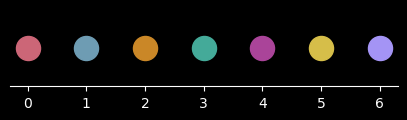

In [3]:
# plt.style.use('default')
# dark_color = [0.2, 0.2, 0.2]
# light_color = [0.9, 0.9, 0.9]
# lightness_0 = 0.75
# lightness_1 = 0.5
plt.style.use("dark_background")
dark_color = [0.7, 0.7, 0.7]
light_color = [0.1, 0.1, 0.1]
lightness_0 = 1.15
lightness_1 = 1.5
colors = set_custom_rcParams()
# Set axis spines visibility
plt.rc(
    "axes.spines",
    **{
        "left": False,
        "right": False,
        "bottom": True,
        "top": False,
    },
)
plt.rcParams["axes.grid"] = False

plot_colors(colors)
variables_color = dict()
variables_color["NAO"] = colors[0]
variables_color["AMO"] = colors[2]
variables_color["sin"] = colors[1]
variables_color["latent"] = colors[3]

In [4]:
REPO_PATH = Path(".").resolve().parent
results_path = REPO_PATH / Path("results") / "Presentation"
results_path.mkdir(parents=True, exist_ok=True)
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    store_path = results_path / relative_path
    store_path.parent.mkdir(parents=True, exist_ok=True)
    if SAVE_FIGURES:
        fig.savefig(store_path, **kwargs)
    else:
        pass

In [5]:
# ValueError: unable to decode time units 'months since 1850-01-15' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.
AMO = xr.load_dataset(REPO_PATH / Path("data/observations/ClimateExplorer/iamo_hadsst.nc"), decode_times=False)
# AMO["time"] = xr.CFTimeIndex()
# NAO_date = pd.date_range(start="1948-01-01", periods=len(NAO_np), freq="MS")
months = AMO.time % 12 + 1
years = np.floor(AMO.time / 12) + 1850
date = cftime.num2date(AMO.time.values, units="months since 1850-01-15", calendar = '360_day')
# date = np.empty_like(years, dtype = cftime.datetime)
# for idx in range(len(months)):
#     date[idx] = cftime.datetime(years[idx], months[idx], 15)
AMO["time"] = date
# smooth 
AMO

<xarray.Dataset>
Dimensions:  (time: 2088)
Coordinates:
  * time     (time) object 1850-01-15 00:00:00 ... 2023-12-15 00:00:00
Data variables:
    AMO      (time) float32 0.2303 0.0542 -0.006336 0.05335 ... nan nan nan nan
Attributes: (12/46)
    title:                               Difference between iadded2.dat and null
    description:                         AMO hadsst
    scripturl01:                         http://climexp.knmi.nl/getindices.cg...
    reference:                           Kennedy et al. (2019), https://www.m...
    file:                                iadded2.dat
    olderfile:                           dummy.12.dat
    ...                                  ...
    index_11_references:                 Morice, C.P., J.J. Kennedy, N.A. Ray...
    index_11_climexp_url:                https://climexp.knmi.nl/getindices.c...
    index_11_history:                    retrieved Thu May 25 22:14:46 UTC 2023
    scripturl02:                         http://climexp.knmi.nl/dat2nc.cgi?id...
    history:                              2023-07-04  8:56:02 ./bin/dat2nc da...
    Conventions:                         CF-1.0

In [6]:
# ValueError:unable to decode time units 'months since 1821-01-15' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.
NAO = xr.load_dataset(REPO_PATH / Path("data/observations/ClimateExplorer/inao.nc"), decode_times=False)
months = NAO.time % 12 + 1
years = np.floor(NAO.time / 12) + 1821
date = cftime.num2date(NAO.time.values, units="months since 1821-01-15", calendar = '360_day')
NAO["time"] = date
NAO

<xarray.Dataset>
Dimensions:  (time: 2424)
Coordinates:
  * time     (time) object 1821-01-15 00:00:00 ... 2022-12-15 00:00:00
Data variables:
    NAO      (time) float32 nan nan nan nan nan ... -3.731 0.859 2.372 nan
Attributes:
    title:        
    description:  NAO-Gibraltar
    scripturl01:  http://climexp.knmi.nl/getindices.cgi?STATION=NAO-Gibraltar...
    institution:  KNMI Climate Explorer and UAE/CRU
    author:       Tim Osborn
    reference:    Jones, P.D., Jónsson, T. and Wheeler, D., 1997: Extension t...
    source:       https://crudata.uea.ac.uk/cru/data/nao/nao_3dp.dat
    comment:      
    scripturl02:  http://climexp.knmi.nl/dat2nc.cgi?id=someone@somewhere&stat...
    history:       2023-07-04  8:55:55 ./bin/dat2nc data/inao.dat i NAO-Gibra...
    Conventions:  CF-1.0

In [42]:
data = xr.merge([NAO, AMO])

data["AMO"] = data["AMO"].rolling(time = 10*12, center = True).mean()


data = data.isel(time = slice(630, None))
mask = np.logical_and(np.isfinite(data.AMO), np.isfinite(data.NAO))
data = data.isel(time = mask)
(~np.isfinite(data)).sum()
data = data.assign_coords(year = data.time.dt.year + data.time.dt.month/12)
data

<xarray.Dataset>
Dimensions:  (time: 1683)
Coordinates:
  * time     (time) object 1878-02-15 00:00:00 ... 2018-04-15 00:00:00
    year     (time) float64 1.878e+03 1.878e+03 ... 2.018e+03 2.018e+03
Data variables:
    NAO      (time) float32 2.202 -0.007 0.447 0.278 ... -0.098 -1.124 2.373
    AMO      (time) float32 0.01139 0.0133 0.008022 ... 0.03157 0.03288 0.03377
Attributes:
    title:        
    description:  NAO-Gibraltar
    scripturl01:  http://climexp.knmi.nl/getindices.cgi?STATION=NAO-Gibraltar...
    institution:  KNMI Climate Explorer and UAE/CRU
    author:       Tim Osborn
    reference:    Jones, P.D., Jónsson, T. and Wheeler, D., 1997: Extension t...
    source:       https://crudata.uea.ac.uk/cru/data/nao/nao_3dp.dat
    comment:      
    scripturl02:  http://climexp.knmi.nl/dat2nc.cgi?id=someone@somewhere&stat...
    history:       2023-07-04  8:55:55 ./bin/dat2nc data/inao.dat i NAO-Gibra...
    Conventions:  CF-1.0

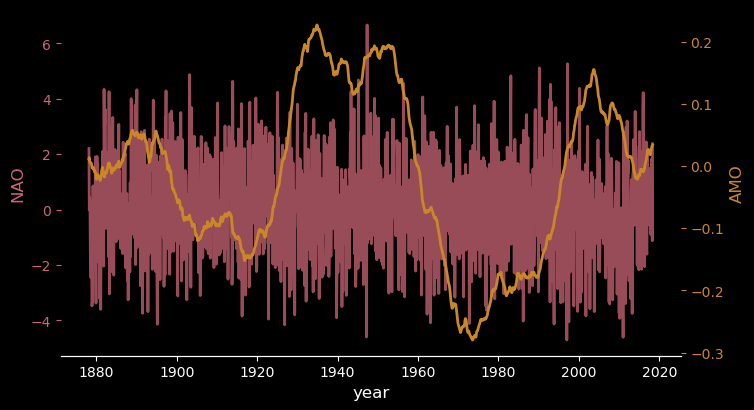

In [43]:
# plot data
fig, ax_NAO = plt.subplots(1, 1)

ax_AMO = ax_NAO.twinx()
# plot NAO
color = variables_color["NAO"]
ax_NAO.plot(data.year, data.NAO, color = color, linewidth = 2, alpha = 0.75)
ax_NAO.set_xlabel("year")
ax_NAO.set_ylabel("NAO")
ax_NAO.spines['right'].set_color(color)
ax_NAO.yaxis.label.set_color(color)
ax_NAO.tick_params(axis='y', colors=color)
# plot AMO
color = variables_color["AMO"]
ax_AMO.plot(data.year, data.AMO, color = color, linewidth = 2)
ax_AMO.set_xlabel("year")
ax_AMO.set_ylabel("AMO")
ax_AMO.spines['right'].set_color(color)
ax_AMO.yaxis.label.set_color(color)
ax_AMO.tick_params(axis='y', colors=color)


In [51]:
# data = normalize(data)

add_random_variable(
    ds=data,
    var_name="latent",
    random_generator=np.random.default_rng(seed=10000),
    dim="time",
    variance=1,
)
add_random_variable(
    ds=data,
    var_name="latent2",
    random_generator=np.random.default_rng(seed=10346),
    dim="time",
    variance=1,
)
# data["sin"] = (
#     np.sin(2 * np.pi * np.arange(0, len(data.time)) / (10 * 12)) + data.AMO * 0
# )
# data["sin"].plot()
nb_iter_SEM = 50
data_kalman = xarray_Kalman_SEM_full_output(
    ds=data,
    observation_variables=["AMO", "NAO"],
    state_variables=["AMO", "NAO", "latent", "latent2"],
    nb_iter_SEM=nb_iter_SEM,
    variance_obs_comp = 0.0001,
    
)
data_kalman["year"] = data.year
data_kalman_states = from_standard_dataset(data_kalman)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


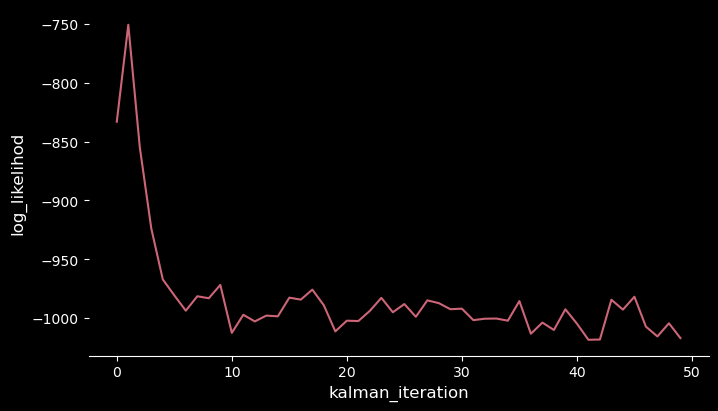

In [52]:
data_kalman["log_likelihod"].plot()

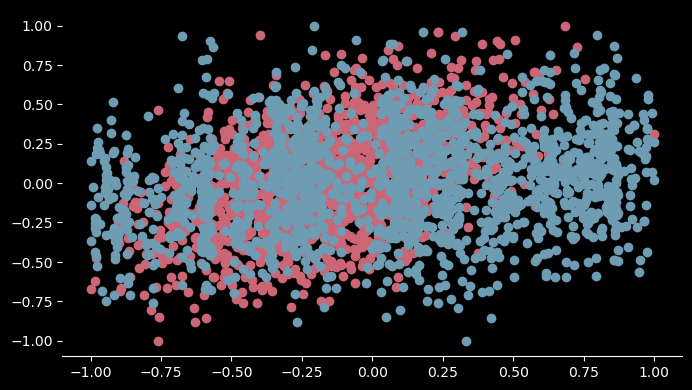

In [53]:
for var in ["NAO", "AMO"]:
    plt.scatter(
        normalize(data[var], "oneone"), 
        normalize(data_kalman_states["latent"].isel(kalman_iteration = -1), "oneone"), 
        label=var)

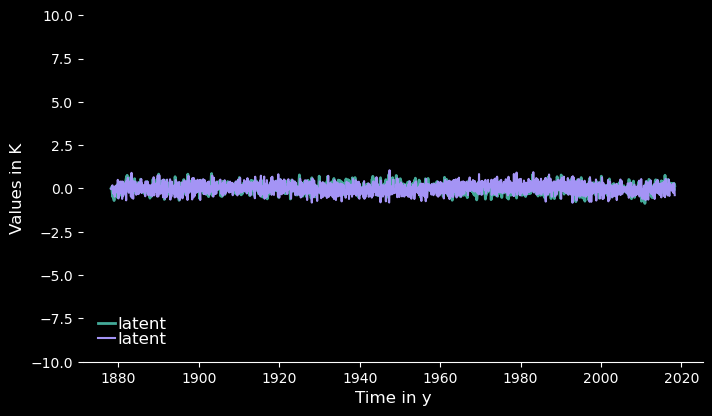

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey = True)
kwargs = dict(
    linestyle="-",
    linewidth="2",
    alpha = 1,
    color = variables_color["latent"]
)

line_latent, = axs.plot(
    data.year,
    data.latent,
    label = "latent",
    **kwargs
    )
line_latent2, = axs.plot(
    data.year,
    data.latent2,
    label = "latent",
    color = colors[-1]
    )
axs.legend( 
        loc = "lower left",
        handlelength = 1,
        labelspacing=0.01,
        handletextpad=0.15,
        columnspacing=0.2,)
    # xlabel
axs.set_xlabel(f"Time in y")
# ylabel 
axs.set_ylim(ymin = -10, ymax = 10)

axs.set_ylabel(f"Values in K")

def init_lines(
        ):
    line_latent.set_ydata(data.latent)
    return line_latent,

def update_lines(
        idx, 
        ):
    if idx == 0:
        line_latent.set_ydata(data.latent)
        line_latent2.set_ydata(data.latent2)
    else :  
        idx -= 1
        line_latent.set_ydata(data_kalman_states.latent.isel(kalman_iteration = idx))
        line_latent2.set_ydata(data_kalman_states.latent2.isel(kalman_iteration = idx))
    return line_latent,

# update_lines(10)

latent_ani = animation.FuncAnimation(
    fig, 
    update_lines,
    init_func=init_lines,
    save_count=nb_iter_SEM+1,
    interval = 100, 
    blit = True,
    )
from IPython.display import HTML
HTML(latent_ani.to_html5_video())
# ani
# To save the animation using Pillow as a gif
# writer = animation.FFMpegWriter(
#     fps=1.5,
#     metadata=dict(artist='Me'),
#     bitrate=-1,
# )
# latent_ani.save(results_path / 'Kalman_SEM_evolution.mp4', writer=writer, dpi = 256)


## Power Spectral Density

In [56]:
fs = 12
# welch_window_width = 150  # years
nperseg = len(data.time)
years = nperseg / fs
print(years)

140.25


In [57]:
# Compute PSD with frequency in year**{-1}
# Set up welch_kwargs to use NO welch method.
welch_kwargs = dict(
    fs = fs,                    # period is 1/12 y -> fs = 12 y^{-1} 
    nperseg = nperseg,   # length in timesteps
    scaling = "density",
    window = "boxcar"
)

psd_data = xarray_dataset_welch(data, dim="time", welch_kwargs=welch_kwargs)
psd_data_kalman = xarray_dataset_welch(data_kalman_states, dim="time", welch_kwargs=welch_kwargs)


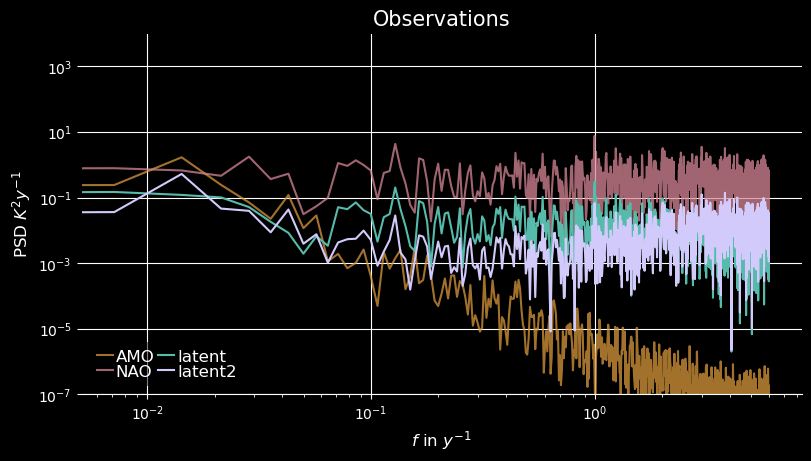

In [59]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, layout="constrained", sharex=True, sharey=True
)
kwargs = dict(
    linestyle="-",
    linewidth="1",
    marker=".",
)

ax.set_title("Observations")

# ------------------
# plot Sponge
# ------------------
var = "AMO"
psd_AMO, = ax.loglog(
        psd_data.frequency, 
        psd_data[var], 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
        alpha = 0.75,
    )
var = "NAO"
psd_NAO, = ax.loglog(
        psd_data.frequency, 
        psd_data[var], 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
        alpha = 0.75,
    )
var = "latent"
psd_latent, = ax.loglog(
        psd_data_kalman.frequency, 
        psd_data_kalman[var].isel(kalman_iteration = 0), 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
    )
var = "latent2"
psd_latent2, = ax.loglog(
        psd_data_kalman.frequency, 
        psd_data_kalman[var].isel(kalman_iteration = 0), 
        label=var, 
        color=adjust_lightness(colors[-1], lightness_0),
    )

ax.legend(
    ncols=2, 
    loc = "lower left",
    handlelength = 1,
    labelspacing=0.01,
    handletextpad=0.15,
    columnspacing=0.2,
    )

ax.set_ylim(
    ymin = 10**(-7),
    ymax = 10**(4))
# fig.suptitle(
#     f"Power Density Spectrum of Latent variable, Observations and hidden Component"
# )
ax.set_ylabel(r"PSD $K^{2}y^{-1}$")

ax.set_xlabel(r"$f$ in $y^{-1}$")
ax.grid()
    
def init_lines(
        ):
    psd_latent.set_ydata(psd_data["latent"])
    psd_latent2.set_ydata(psd_data["latent2"])
    return psd_latent, psd_latent2,

def update_lines(
        idx, 
        ):
    if idx == 0:
        psd_latent.set_ydata(psd_data["latent"])
        psd_latent2.set_ydata(psd_data["latent2"])
    else : 
        idx -= 1
        psd_latent.set_ydata(psd_data_kalman["latent"].isel(kalman_iteration = idx))
        psd_latent2.set_ydata(psd_data_kalman["latent2"].isel(kalman_iteration = idx))
    return psd_latent, psd_latent2,

init_lines()
update_lines(40)

ani_PSD = animation.FuncAnimation(
    fig, 
    update_lines,
    init_func=init_lines,
    save_count=nb_iter_SEM+1,
    interval = 200, 
    blit = True,
    )
from IPython.display import HTML
HTML(ani_PSD.to_html5_video())
# ani_PSD
# # # To save the animation using Pillow as a gif
# writer = animation.FFMpegWriter(
#     fps=1.5,
#     metadata=dict(artist='Me'),
#     bitrate=-1,
# )
# ani_PSD.save(results_path / 'PSD_evolution.mp4', writer=writer, dpi = 256)
